In [1]:
%matplotlib inline

In [2]:
import numpy as np
from nighres import io
import pandas as pd
import nibabel as nb
import matplotlib.pyplot as plt
import pickle

### Load mesh, normals (retrieved from Paraview) and data

In [3]:
mesh = io.load_mesh_geometry("/home/julia/data/gradients/atlas/allen_api/brain_mesh.vtk")

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2444: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2447: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [4]:
normals = np.load("/home/julia/data/gradients/atlas/allen_api/brain_mesh_normals.npy")

In [5]:
data = nb.load("/home/julia/data/gradients/results/gradient0000_highres_allen.nii.gz").get_data()

In [6]:
mask = nb.load("/home/julia/data/gradients/atlas/cortex/cortex_mask_25um_allen.nii.gz").get_data()

In [7]:
data[mask==0]=np.nan

(-0.5, 455.5, 319.5, -0.5)

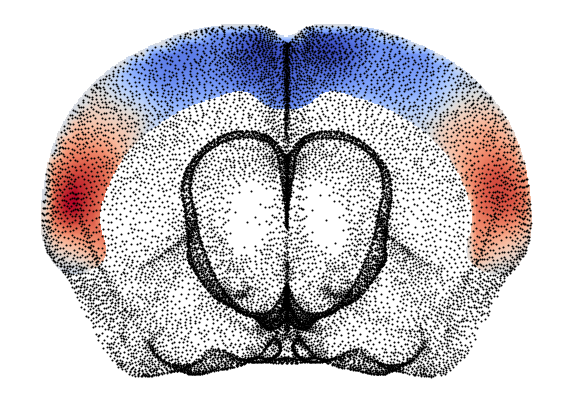

In [8]:
x = 250
fig = plt.figure(figsize=(10,10))
mesh_slice = mesh['points'][(mesh['points'][:,0]-x*25)<1][:,1:]/25
plt.scatter(mesh_slice[:,1], mesh_slice[:,0], s=1, color='black');
plt.imshow(data[x, :, :], cmap='coolwarm');
plt.axis('off')

In [9]:
mesh_cortex = np.zeros_like(data)
for n in mesh["points"]:
    voxel = np.array(np.floor(n/25), dtype="int16")
    if not np.isnan(data[voxel[0], voxel[1], voxel[2]]):
        mesh_cortex[voxel[0], voxel[1], voxel[2]]=1
mesh_cortex[mesh_cortex==0]=np.nan

(-0.5, 455.5, 319.5, -0.5)

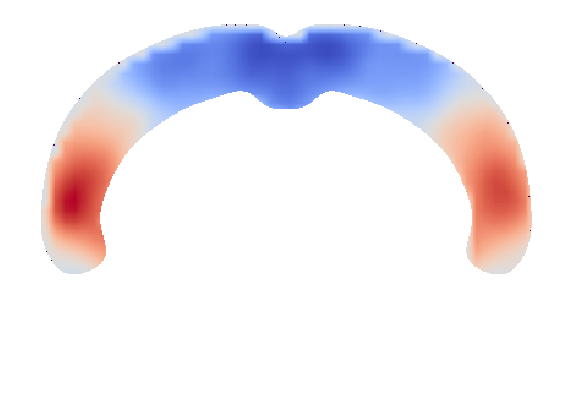

In [10]:
x = 250
fig = plt.figure(figsize=(10,10))
plt.imshow(data[x, :, :], cmap='coolwarm');
plt.imshow(mesh_cortex[x, :, :]);
plt.axis('off')

### Sample data along normal until data ends (one node)

In [24]:
voxel = np.array(np.floor(mesh["points"][0]/25), dtype="int16")
sample = [data[voxel[0], voxel[1], voxel[2]]]
voxels = [voxel]
counts = []

point = mesh["points"][0] - normals[0]
while not np.isnan(data[voxel[0], voxel[1], voxel[2]]):
    # move along the normal
    point = point - normals[0]
    voxel = np.array(np.floor(point/25), dtype="int16")
    # if this is a new voxel, sample
    if not np.all(voxels[-1]==voxel):
        sample.append(data[voxel[0], voxel[1], voxel[2]])
        voxels.append(voxel)

In [25]:
test = np.zeros_like(mask)
for v in range(len(voxels)):
    test[voxels[v][0], voxels[v][1], voxels[v][2]]=v+1
test[test==0]=np.nan

In [26]:
voxels[0]

array([315, 135,  20], dtype=int16)

(-0.5, 455.5, 319.5, -0.5)

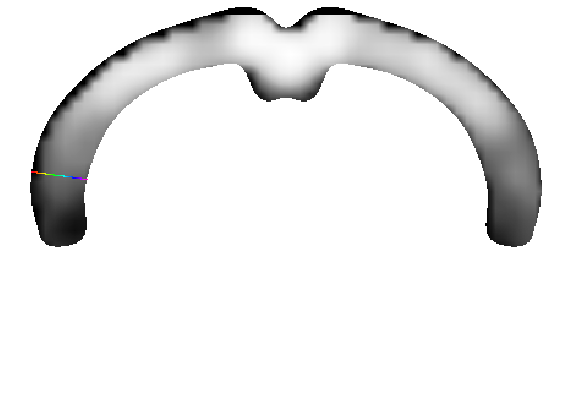

In [27]:
x = 315
fig = plt.figure(figsize=(10,10))
plt.imshow(mask[x, :, :], cmap='Greys');
plt.imshow(test[x, :, :], cmap='gist_rainbow');
plt.axis('off')

### Loop over all points

In [8]:
mesh_data = np.zeros(len(mesh["points"]))
qa_voxels = []

for p in range(len(mesh["points"])):
    sample = []
    voxels = []
    first_round = True
    
    point = mesh["points"][p]

    while True:
        if first_round is True:
            voxel = np.array(np.floor(point/25), dtype="int16")
            same_voxel = False
            first_round = False
        else: 
            # move forward
            point = point - normals[p]
            voxel = np.array(np.floor(point/25), dtype="int16")
            # check if this is a new voxel
            same_voxel = np.all(voxels[-1]==voxel)

        if same_voxel == False:
            # check that voxel is still in image
            try:
                value = data[voxel[0], voxel[1], voxel[2]]
            except IndexError:
                break

            # when outside the cortex mask
            if np.isnan(value) == True:
                # allow to go on for a few voxels in the beginning
                if len(voxels) < 5:
                    pass
                # if the nan occurs later, stop sampling
                else:
                    break
            # if inside mask, sample value
            else:
                sample.append(value)
            voxels.append(voxel)
            
            if len(voxels) >=50:
                break

    mesh_data[p] = np.nanmean(sample)
    qa_voxels.append(voxels)

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


In [24]:
with open('/home/julia/data/gradients/results/qa_voxels.pkl', 'wb') as filehandle:
    pickle.dump(qa_voxels, filehandle)

In [9]:
mesh_data = np.nan_to_num(mesh_data)

In [10]:
np.save("/home/julia/data/gradients/results/gradient0000_mesh.npy", mesh_data)

In [11]:
mesh['data']=mesh_data

In [12]:
io.save_mesh("/home/julia/data/gradients/results/gradient0000_mesh.vtk", mesh)

### QA: Plotting trajectories

In [20]:
qa = np.zeros_like(data)
for p in range(len(mesh["points"])):
    profile = qa_voxels[p]
    if len(profile) > 5:
        for v in range(len(profile)):
            vox = profile[v]
            qa[vox[0], vox[1], vox[2]] = v+1
qa[qa==0]=np.nan

In [23]:
len(qa_voxels)

49324

In [21]:
np.save("/home/julia/data/gradients/results/qa.npy", qa)
aff = nb.load("/home/julia/data/gradients/results/gradient0000_highres_allen.nii.gz").affine
nb.save(nb.Nifti1Image(np.nan_to_num(qa), aff), "/home/julia/data/gradients/results/qa.nii.gz")

(-0.5, 455.5, 319.5, -0.5)

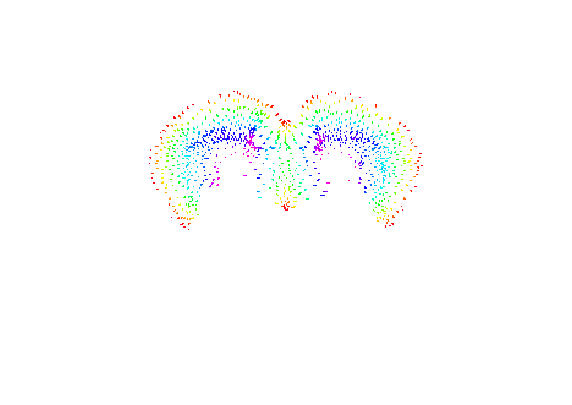

In [22]:
x = 100
fig = plt.figure(figsize=(10,10))
plt.imshow(qa[x, :, :], cmap='gist_rainbow');
plt.axis('off')

### Restricting profile length to cut trajectories that go rouge

In [112]:
profile_length = []
for p in range(len(mesh["points"])):
    profile_length.append(len(qa_voxels[p]))
profile_length=np.asarray(profile_length)

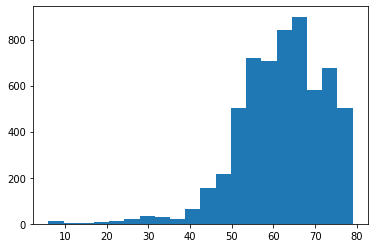

In [120]:
plt.hist(profile_length[(profile_length>5) & (profile_length<80)], bins=20);

In [121]:
profile_length[(profile_length<=5)]=0
profile_length[(profile_length>80)]=0

In [122]:
mesh['data']=np.asarray(profile_length)
io.save_mesh("/home/julia/data/gradients/results/profile_len.vtk", mesh)